# In this notebook, we will be analysing the knowledge graph of the scientific paper:
Hung, Chijung, and Akihiro Yamanaka. "The role of orexin neuron activity in sleep/wakefulness regulation." Peptides (2023): 171007.

# 🪐 Spacy


In [1]:
# !python -m spacy download en_core_web_lg
import spacy
from spacy.tokens import Span
from spacy.tokens import DocBin
from spacy import displacy
from spacy.util import filter_spans
from spacy.matcher import PhraseMatcher
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt


# Import

In [2]:
import os
import re
import spacy
from spacy.tokens import Doc, Span
from spacy import displacy

nlp = spacy.load("en_core_web_lg")

# NER 🤗

### ʕ•́ᴥ•̀ʔっ♡ ktgiahieu/RoBERTa-large-PM-M3-Voc-hf-finetuned-ner-combine-filtered

In [5]:
from transformers import (AutoModelForTokenClassification, 
                          AutoTokenizer, 
                          pipeline,
                          )

model_checkpoint = "ktgiahieu/RoBERTa-large-PM-M3-Voc-hf-finetuned-ner-combine-filtered"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)                                                        
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

model_pipeline = pipeline(task="ner", model=model, tokenizer=tokenizer)

In [6]:
def get_term_chunks(text):
    orig_entities = model_pipeline(text)

    # Define the ClassLabel feature with the label names
    label_list = ['B-Term','B-Lab_value','B-Chemical','I-Term','I-Lab_value','I-Chemical','O']

    entities = []
    for i in range(len(orig_entities)):
        orig_entities[i]['entity'] = label_list[int(orig_entities[i]['entity'][6:])]
        if orig_entities[i]['entity'] == 'O':
            continue
        entities.append(orig_entities[i])

    # Show the results with highlighting

    from ipymarkup import show_span_ascii_markup, show_dep_ascii_markup, show_span_box_markup

    entities_markup = []
    for i in range(len(entities)):
        if len(entities_markup) == 0:
            # while the previous character is not a space or \n, move the start index back
            while entities[i]['start'] > 0 and text[entities[i]['start']-1] not in [' ', '\n']:
                entities[i]['start'] -= 1
            # while the next character is not a space or punctuation, move the end index forward
            while entities[i]['end'] < len(text) and text[entities[i]['end']] not in [' ', '\n', '.', ',', ';', ':', '!', '?', ')', ']', '}', '>', '"', "'", '”', '’', '‘', '›', '»']:
                entities[i]['end'] += 1
            entities_markup.append([entities[i]['start'], entities[i]['end'], entities[i]['entity'][2:]])
            continue
        if (entities[i]['start'] <= entities[i-1]['end'] \
            or entities[i]['start'] <= entities[i-1]['end']+1 \
            # or entities[i]['start'] <= entities[i-1]['end']+2 \
            # or entities[i]['start'] <= entities[i-1]['end']+3 \
        ) and \
            (entities[i]['entity'][2:] == entities[i-1]['entity'][2:] \
             or (entities[i]['entity'][2:] in ['Term', 'Chemical'] and entities[i-1]['entity'][2:] in ['Term', 'Chemical'])):
            # while the next character is not a space or punctuation, move the end index forward
            while entities[i]['end'] < len(text) and text[entities[i]['end']] not in [' ', '\n', '.', ',', ';', ':', '!', '?', ')', ']', '}', '>', '"', "'", '”', '’', '‘', '›', '»']:
                entities[i]['end'] += 1
            entities_markup[-1][1] = entities[i]['end']
        else:
            # while the previous character is not a space or \n, move the start index back
            while entities[i]['start'] > 0 and text[entities[i]['start']-1] not in [' ', '\n']:
                entities[i]['start'] -= 1
            # while the next character is not a space or punctuation, move the end index forward
            while entities[i]['end'] < len(text) and text[entities[i]['end']] not in [' ', '\n', '.', ',', ';', ':', '!', '?', ')', ']', '}', '>', '"', "'", '”', '’', '‘', '›', '»']:
                entities[i]['end'] += 1
            entities_markup.append([entities[i]['start'], entities[i]['end'], entities[i]['entity'][2:]])

    term_chunks = [{
        'start': chunk[0],
        'end': chunk[1],
        'label': chunk[2],
        'text': text[chunk[0]:chunk[1]]
    }
        for chunk in entities_markup
    ]
    return term_chunks

In [7]:
def get_term_chunks_long_text(long_text):
    # split the long text into chunks by \n
    texts = []
    current_text = ''
    for text_chunk in long_text.split('\n'):
        current_text += text_chunk + '\n'
        if len(current_text) > 0 and len(current_text) < 100:
            continue
        texts.append(current_text)
        current_text = ''

    # get the term chunks for each text chunk
    term_chunks = []
    text_prev_len = 0
    for i, text in enumerate(texts):
        try:
            new_term_chunks = get_term_chunks(text)
        except:
            new_term_chunks = []
            new_term_chunks += get_term_chunks(text[:len(text)//2])
            new_half_term_chunks = get_term_chunks(text[len(text)//2:])
            for j in range(len(new_half_term_chunks)):
                new_half_term_chunks[j]['start'] += len(text)//2
                new_half_term_chunks[j]['end'] += len(text)//2
            new_term_chunks += new_half_term_chunks


                
                
        if i==0:
            term_chunks += new_term_chunks
            text_prev_len += len(text)
        else:
            # add the length of the previous text chunk to the start and end indices of the current text chunk
            for j in range(len(new_term_chunks)):
                # print('Before:', new_term_chunks[j]['start'], new_term_chunks[j]['end'])
                new_term_chunks[j]['start'] += text_prev_len
                new_term_chunks[j]['end'] += text_prev_len
                # print('After:', new_term_chunks[j]['start'], new_term_chunks[j]['end'])
            term_chunks += new_term_chunks
            text_prev_len += len(text)
    return term_chunks

# Find the predicates

In [8]:
def get_predicates_between_term_chunks(doc, term_chunks):
    predicates = []
    sources = []
    targets = []

    for i in range(len(term_chunks) - 1):
        start_chunk_token = doc.char_span(
            term_chunks[i]['start'], term_chunks[i]['end'])
        end_chunk_token = doc.char_span(
            term_chunks[i + 1]['start'], term_chunks[i + 1]['end'])
        
        if start_chunk_token is None or end_chunk_token is None or start_chunk_token.sent != end_chunk_token.sent:
            continue

        # Find the shortest path between the root tokens of the neighboring noun chunks
        start_token = start_chunk_token.root
        end_token = end_chunk_token.root

        # not ideal, can possibly be shortened:
        predicate_tokens = []
        if start_token in end_token.ancestors:
            ancs = end_token.ancestors
            stop = start_token
        elif end_token in start_token.ancestors:
            ancs = start_token.ancestors
            stop = end_token
        else:
            for token in end_token.ancestors:
                predicate_tokens.append(token)
                if token in end_token.ancestors:
                    break
            ancs = end_token.ancestors
            stop = token
        for tok in ancs:
            if tok == stop:
                break
            predicate_tokens += [tok]
    

        if not predicate_tokens:
            continue
        predicate_tokens = sorted(
            predicate_tokens, key=lambda token: token.i)
        predicate_text = ' '.join(token.text for token in predicate_tokens)
        start_char = predicate_tokens[0].idx
        end_char = start_char + len(predicate_text)
        
        predicates.append({
            'start': start_char,
            'end': end_char,
            'label': 'PRED',
            'text': predicate_text
        })
        sources += [start_chunk_token]
        targets += [end_chunk_token]
        # print(
        #     f'{predicate_text} :: {start_chunk_token} _______ { end_chunk_token}')

    return predicates, sources, targets


text = """
1. Introduction
Sleep/wakefulness in mammals is roughly divided into the three vigilance states: wakefulness, rapid eye movement (REM) sleep and non-REM (NREM) sleep [1]. The lateral hypothalamus (LH) has an important role in regulating the change between states. A role for LH in sleep/wakefulness regulation was first investigated by C. von Economo more than 100 years ago, while destruction/lesion of the LHA caused somnolence in several species [2–9]. In the LH, many neurons synthesize and release different neuropeptides. Orexin (also known as hypocretin) is one of these neuropeptides [10,11]. Intracerebroventricular administration of synthesized orexin peptide in rodents increased wakefulness and suppressed NREM and REM sleep in a dose-dependent manner [12]. In addition, orexin neurons receive inputs from multiple brain areas that are involved in the regulation of sleep/wakefulness. Orexin neurons also project axons throughout the brain and spinal cord to modulate downstream neuronal activity by orexin itself and with other co-transmitters that are synthesized in the orexin neurons and released with orexin.
A classic and certain method for studying the physiological function of target neurons is to ablate them from brain and analyze any resulting abnormalities. Orexin/ataxin-3 mice were generated to understand the function of orexin neurons by ablating them as a way to mimic orexin neuron–specific degeneration in human narcolepsy. In these mice, orexin neurons are gradually ablated after birth by the cell-specific expression of the triplet repeat region of the ataxin-3 gene, which in- duces apoptosis. Orexin/ataxin-3 mice reproduce symptoms of narco- lepsy, such as fragmental sleep/wakefulness and cataplexy [41]. To better mimic human narcolepsy, which has an onset in adolescence, Tet-off system–controlled diphtheria toxin A (DTA) gene expression was applied to reveal the relationship between the number of orexin neurons and narcolepsy symptoms [42]. Orexin-tetracycline trans-activator (tTA) mice [43,44], in which tTA is exclusively expressed in orexin neurons under the control of a human prepro-orexin promoter, were bred with TetO DTA mice to generate bigenic orexin-tTA; TetO DTA mice. DTA induces cell death by inhibiting the function of an elongation factor involved in protein synthesis. DTA expression can be controlled by the presence or absence of doxycycline (DOX). DOX was supplied through the diet by chow containing DOX (100 mg/kg). Removal of DOX from the diet initiates ablation of orexin neurons at the desired time, for example, in adulthood after development. Ablation of orexin neurons in adulthood induced more severe symptoms of narcolepsy compared to orexin/ataxin-3 mice. The severity of symptoms was related to the number of remaining orexin neurons. Orexin-tTA; TetO DTA mice losing more than 80% of orexin neurons started to show fragmental sleep/- wakefulness. Mice losing more than 95% of orexin neurons started showing cataplexy, and the severity of cataplexy more than 95% loss of orexin neurons. In this narcolepsy model mice, sex differences in the onset of narcolepsy symptoms were also examined. Females exhibited cataplexy earlier than males, but both sexes eventually developed all symptoms of narcolepsy [45]. These orexin neurons ablated mice mimicked human narcolepsy and contributed to reveal the mechanism of symptoms in narcolepsy.
"""

doc = nlp(text)
displacy.render(doc, style="dep")
term_chunks = get_term_chunks_long_text(text)
predicates, sources, targets = get_predicates_between_term_chunks(
    doc, term_chunks)

funkycolor = "linear-gradient(90deg, #aa9cfc, #fc9ce7)"
displacy.render({'text': text, 'ents': term_chunks + predicates,
                'title': None}, style='ent', manual=True, jupyter=True, options={'colors': {"PRED": funkycolor,
                # blue
                'Chemical': "linear-gradient(90deg, #00FFFF, #0096FF)", 
                'Term': "linear-gradient(90deg, #00D100, #2EFF2E)",
                'Lab_value': "linear-gradient(90deg, #fdc500, #fe7f2d)"}})


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


# Create the semantic graph

inspired by https://www.kaggle.com/code/cananserper/knowledge-graph-spacy  

In [9]:
df = pd.DataFrame({'source': [str(s) for s in sources], 'target': [str(t) for t in targets], 'edge': [r['text'] for r in predicates]})
df

,source,target,edge
0,rapid eye movement,(NREM,sleep REM
1,Orexin,hypocretin,known as
2,peptide,REM,sleep
3,triplet repeat region,ataxin-3,of gene
4,Orexin/ataxin-3,fragmental,reproduce symptoms of lepsy as wakefulness
5,Tet-off system–controlled diphtheria toxin A,(DTA,expression
6,Orexin-tetracycline trans-activator,(tTA,activator
7,(tTA,tTA,expressed
8,tTA,prepro-orexin promoter,of
9,prepro-orexin promoter,TetO DTA,with


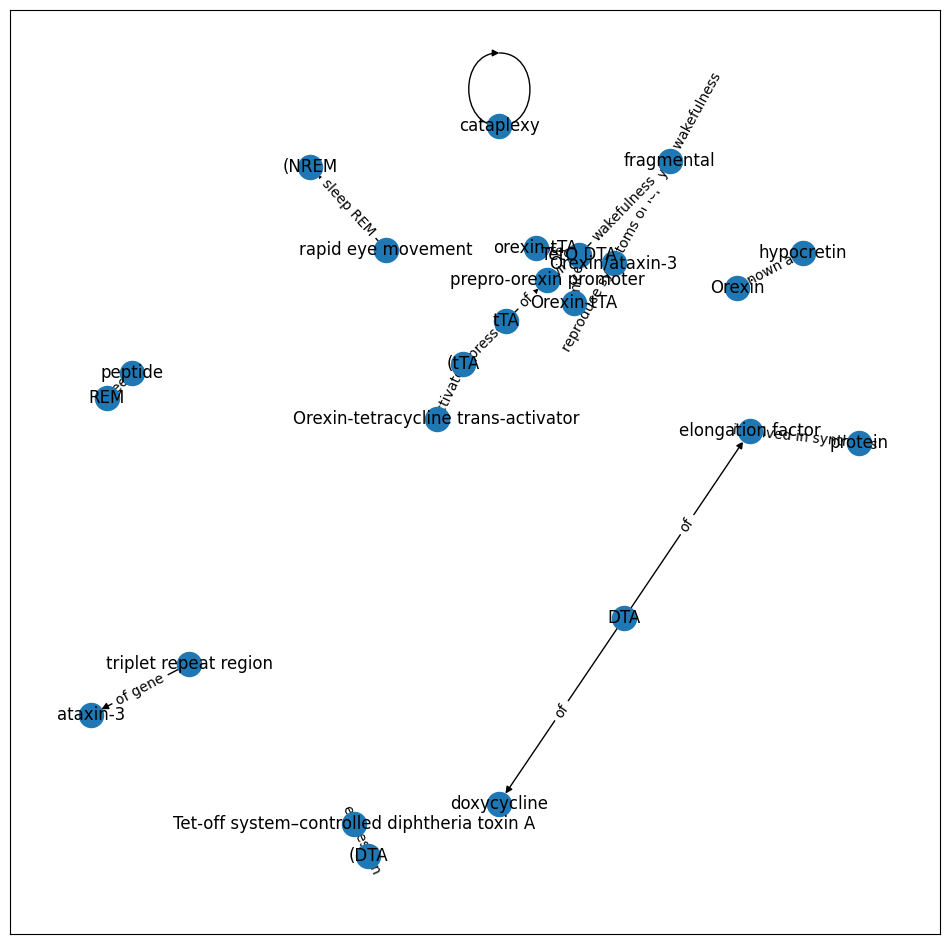

In [10]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()


# Merge synonyms entities together to simplify the relations

In [11]:
from tqdm import tqdm
# Define a function to merge the list of similar words
def merge_similar_words(words):
    merged_words = []
    for j, word in tqdm(enumerate(words), total=len(words)):
        if len(merged_words) == 0:
            merged_words.append(word)
            continue
        # Create a Spacy Doc object for the word
        doc = nlp(word)
        # Calculate the similarity scores between the word and each word in the merged list
        similarity_scores = [doc.similarity(nlp(w)) if i!=j else 0 for i, w in enumerate(merged_words)]
        # If the maximum similarity score is above a certain threshold, add the word to the group
        if similarity_scores and max(similarity_scores) > 0.8:
            index = similarity_scores.index(max(similarity_scores))
            merged_words.append(merged_words[index])
        # Otherwise, start a new group
        else:
            merged_words.append(word)
    return merged_words


In [12]:
grouped_sources = merge_similar_words([str(s) for s in sources])
grouped_targets = merge_similar_words([str(t) for t in targets])
grouped_predicates = merge_similar_words([r['text'] for r in predicates])
df = pd.DataFrame({'source': grouped_sources, 'target': grouped_targets, 'edge': grouped_predicates})
df

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 39%|███▉      | 7/18 [00:00<00:00, 56.47it/s]/var/folders/91/2fbkbbgj7471rgv8k0yy0sn40000gn/T/ipykernel_37230/1806939086.py:12: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  similarity_scores = [doc.similarity(nlp(w)) if i!=j else 0 for i, w in enumerate(merged_words)]
100%|██████████| 18/18 [00:00<00:00, 26.49it/s]


,source,target,edge
0,rapid eye movement,(NREM,sleep REM
1,Orexin,hypocretin,known as
2,peptide,REM,sleep REM
3,triplet repeat region,ataxin-3,of gene
4,Orexin/ataxin-3,fragmental,reproduce symptoms of lepsy as wakefulness
5,Tet-off system–controlled diphtheria toxin A,(NREM,expression
6,Orexin-tetracycline trans-activator,(NREM,activator
7,(tTA,tTA,expressed
8,tTA,prepro-orexin promoter,of gene
9,Orexin-tetracycline trans-activator,TetO DTA,with


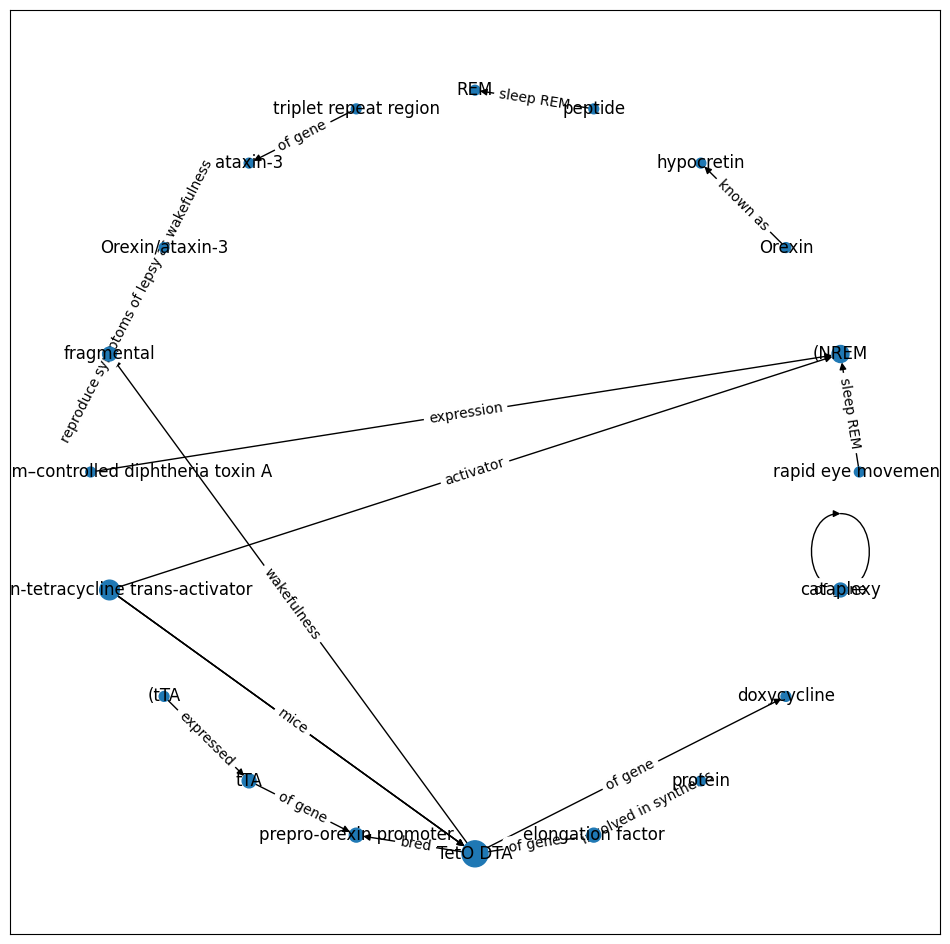

In [13]:
G = nx.from_pandas_edgelist(df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())
plt.figure(figsize=(12, 12))

node_sizes = [50 * G.degree(node) for node in G.nodes()]
pos = nx.circular_layout(G)
nx.draw_networkx(G, with_labels=True, pos=pos, node_size=node_sizes)

# Add edge labels
edge_labels = {(row['source'], row['target']): row['edge']
               for _, row in df.iterrows()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.show()
